In [35]:
from catboost import CatBoostClassifier
from scipy import signal
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error


# Дозагрузка данных (ВВП, Модели, )

In [21]:
gdp_list_p = pd.read_csv('OuterFiles/gdp_processed.csv')


In [22]:
model = tf.keras.saving.load_model("Models/time_series.h5")
cbc_wo_pensia_load = CatBoostClassifier()
cbc_wo_pensia_load.load_model('Models/classificator_catboost_wo_pensia.pkl')


In [2]:
npo_clnts = pd.read_csv('DATA/Test/npo_clnts.csv')
npo_cntrbtrs = pd.read_csv('DATA/Test/npo_cntrbtrs.csv')
npo_trnsctns = pd.read_csv('DATA/Test/npo_trnsctns.csv')


# Функции обработки

In [23]:
def create_vector_user(user_table):
  important_series_columns_for_vector = [
      'npo_sum',
      'npo_operation_group',
      'npo_operation_date_year',
      'npo_operation_date_month',
      'npo_operation_date_day'
  ]
  important_constant_columns_for_voctor = ['accnt_pnsn_schm',
                                           'npo_accnt_status', 'npo_blnc', 'npo_pmnts_sum', 'npo_pmnts_nmbr',
                                           'npo_ttl_incm', 'npo_accnt_status_date_year',
                                           'npo_accnt_status_date_month', 'npo_accnt_status_date_day',
                                           'npo_frst_pmnt_date_year', 'npo_frst_pmnt_date_month',
                                           'npo_frst_pmnt_date_day', 'npo_lst_pmnt_date_year',
                                           'npo_lst_pmnt_date_month', 'npo_lst_pmnt_date_day', 'gndr', 'brth_yr',
                                           'pstl_code', 'city'
                                           ]
  constant_vector_params = user_table.loc[:, important_constant_columns_for_voctor].describe(
  ).loc['mean'].to_numpy()
  series_vector_describe = user_table.loc[:,
                                          important_series_columns_for_vector].describe().T
  series_vector_params = series_vector_describe.loc[:, [
      'mean', 'std', 'min', 'max']].to_numpy().reshape(20, )
  return np.insert(np.append(series_vector_params, constant_vector_params), 0, np.mean(series_vector_describe['count']))


In [24]:
def mod_user(a, gdps, space):
    data = a.sort_values(by=['npo_operation_date_year',
                         'npo_operation_date_month', 'npo_operation_date_day'])
    u1d = create_vector_user(data)
    class_of_user = cbc_wo_pensia_load.predict(u1d.reshape(1, u1d.shape[0]))
    gdp = list()
    for i in data.loc[:, ['npo_operation_date_month', 'npo_operation_date_year']].to_numpy():
        res = gdps.loc[(gdps['month'] + space['month'] == i[0])
                       & (gdps['year'] + space['year'] == i[1])]
        if res.shape[0]:
            gdp.append(res['gdv'].median())
        else:
            gdp.append(-1)
    data_npo_sum = data['npo_sum'].to_numpy().reshape(1, data.shape[0])
    gdp = np.array(gdp).reshape(1, data.shape[0])
    c = np.append(data_npo_sum, gdp, axis=0)
    f = signal.resample(c.T, 100).T
    f = f.reshape(1, f.shape[0] * f.shape[1])
    f = np.insert(f, 0, class_of_user)
    return f


In [3]:
def trans_a(a):
    try:
        if type(a) is str:
            return float(a.replace('\xa0', ''))
        else:
            return float(a)
    except:
        return -1


# Предобработка валидационного датасета

In [4]:
not_importe_col_for_npo_clnts = ['age']
npo_clnts_normed = npo_clnts.drop(not_importe_col_for_npo_clnts, axis=1)
npo_clnts_normed['pstl_code'] = npo_clnts_normed['pstl_code'].apply(trans_a)


In [5]:
npo_cntrbtrs_normed = npo_cntrbtrs
date_columns_for_npo_cntrbtrs = [
    'npo_accnt_status_date', 'npo_frst_pmnt_date', 'npo_lst_pmnt_date']
for i in date_columns_for_npo_cntrbtrs:
    npo_cntrbtrs_normed[f'{i}_year'] = pd.to_datetime(npo_cntrbtrs[i]).dt.year
    npo_cntrbtrs_normed[f'{i}_month'] = pd.to_datetime(
        npo_cntrbtrs[i]).dt.month
    npo_cntrbtrs_normed[f'{i}_day'] = pd.to_datetime(npo_cntrbtrs[i]).dt.day
    npo_cntrbtrs_normed = npo_cntrbtrs_normed.drop(i, axis=1)


In [6]:
npo_trnsctns_normed = npo_trnsctns
date_columns_for_npo_trnsctns = ['npo_operation_date']
for i in date_columns_for_npo_trnsctns:
    npo_trnsctns_normed[f'{i}_year'] = pd.to_datetime(npo_trnsctns[i]).dt.year
    npo_trnsctns_normed[f'{i}_month'] = pd.to_datetime(
        npo_trnsctns[i]).dt.month
    npo_trnsctns_normed[f'{i}_day'] = pd.to_datetime(npo_trnsctns[i]).dt.day
    npo_trnsctns_normed = npo_trnsctns_normed.drop(i, axis=1)


In [7]:
npo_cntrbtrs_fillna = npo_cntrbtrs_normed.fillna(-1)
npo_trnsctns_fillna = npo_trnsctns_normed.fillna(-1)
npo_clnts_fillna = npo_clnts_normed.fillna(-1)


In [8]:
all_in_one = pd.merge(npo_trnsctns_fillna, npo_cntrbtrs_fillna, on='npo_accnt_id')
all_in_one = pd.merge(all_in_one, npo_clnts_fillna, on='clnt_id')


In [9]:
all_in_one.columns


Index(['npo_accnt_id', 'npo_sum', 'slctn_nmbr_x', 'npo_operation_group',
       'npo_operation_date_year', 'npo_operation_date_month',
       'npo_operation_date_day', 'clnt_id', 'accnt_pnsn_schm', 'slctn_nmbr_y',
       'npo_accnt_status', 'npo_blnc', 'npo_pmnts_sum', 'npo_pmnts_nmbr',
       'npo_ttl_incm', 'npo_accnt_status_date_year',
       'npo_accnt_status_date_month', 'npo_accnt_status_date_day',
       'npo_frst_pmnt_date_year', 'npo_frst_pmnt_date_month',
       'npo_frst_pmnt_date_day', 'npo_lst_pmnt_date_year',
       'npo_lst_pmnt_date_month', 'npo_lst_pmnt_date_day', 'gndr',
       'slctn_nmbr', 'brth_yr', 'pstl_code', 'city'],
      dtype='object')

In [10]:
all_in_one.to_csv('DATA/Test/all_in_one.csv')


In [12]:
all_in_one['slctn_nmbr'] = all_in_one['slctn_nmbr_x']
all_in_one = all_in_one.drop(['slctn_nmbr_x', 'slctn_nmbr_y', ], axis=1)


In [13]:
all_in_one.shape


(5301008, 27)

In [16]:
clients_sums = dict()
clients = all_in_one['clnt_id'].unique()
for i in clients[0:2000]:
    clients_sums[i] = all_in_one.loc[all_in_one['clnt_id'] == i]


In [27]:
len(list(clients_sums.keys()))

2000

In [20]:
with open('DATA/Test/clients_sums.pkl', 'wb') as fp:
    pickle.dump(clients_sums, fp)


In [26]:
with open('DATA/Test/clients_sums.pkl', 'rb') as fp:
    clients_sums = pickle.load(fp)


In [28]:
data = list(clients_sums.values())


# Создание валидационной выборки (разбиение на x и y)

In [30]:
dataset_preprocessed_TS = list(map(lambda a: mod_user(a, gdp_list_p, space={'month': 4, 'year': 1}), list(clients_sums.values()),))

In [31]:
dataset_preprocessed_x, dataset_preprocessed_y = [], []
for i in dataset_preprocessed_TS:
    dataset_preprocessed_y.append(i[76:101])
    x = np.delete(i, np.arange(75, 100) + 1)
    x = np.delete(x, np.arange(75, 100) + 1 + 100 - 25)
    dataset_preprocessed_x.append(x)


In [32]:
dataset_preprocessed_x = np.array(dataset_preprocessed_x)
dataset_preprocessed_y = np.array(dataset_preprocessed_y)


In [33]:
pred = model.predict(dataset_preprocessed_x)


63/63 [==============================] - 0s 2ms/step


# Метрики

In [51]:
r2_score(dataset_preprocessed_y[0:100], pred[0:100]), r2_score(np.mean(dataset_preprocessed_y, axis=0), np.mean(pred, axis=0)), r2_score(np.median(dataset_preprocessed_y, axis=0), np.median(pred, axis=0))


(0.05419180982942642, 0.2013833882603916, 0.4022521683892837)

In [45]:
mean_absolute_error(dataset_preprocessed_y, pred)


2062.2831935850986

In [54]:
class1 = dataset_preprocessed_x[:, 0] == 1
class2 = dataset_preprocessed_x[:, 0] == 2
class3 = dataset_preprocessed_x[:, 0] == 3
class0 = dataset_preprocessed_x[:, 0] == 0


In [60]:
print('Открытый кролик', r2_score(dataset_preprocessed_y[class0], pred[class0]))
print('Смелый кролик', r2_score(dataset_preprocessed_y[class1][:100], pred[class1][:100]))
print('Предприимчивый кролик', r2_score(dataset_preprocessed_y[class2][:100], pred[class2][:100]))
print('Осторожный кролик', r2_score(dataset_preprocessed_y[class3][:100], pred[class3][:100]))


Открытый кролик 0.0423552136232184
Смелый кролик -3.791585277969782
Предприимчивый кролик 0.04032469744995813
Осторожный кролик 0.14080128113977744


Видим, что сильно выделяется "Смелый кролик" (1 класс), это и обоснованно, т.к. это наименее предсказуеммый тип по своей природе

In [62]:
import matplotlib.pyplot as plt


([0, 1, 2, 3],
 [Text(0, 0, 'Открытый кролик'),
  Text(1, 0, 'Предприимчивый кролик'),
  Text(2, 0, 'Осторожный кролик'),
  Text(3, 0, 'Смелый кролик')])

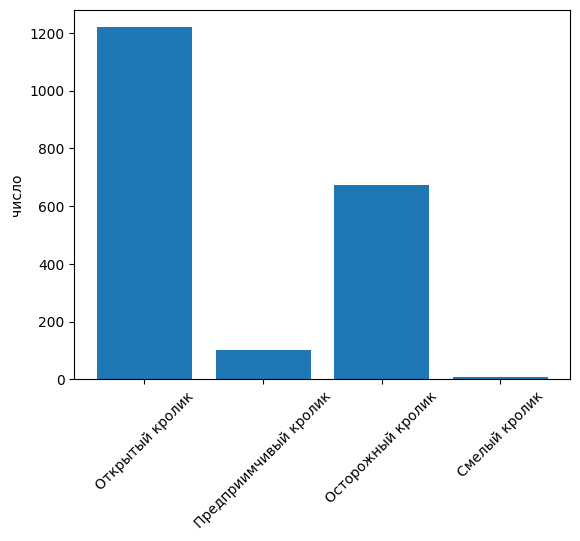

In [71]:
from collections import Counter
x = Counter(dataset_preprocessed_x[:, 0].T.tolist())
r = {"3": "Осторожный кролик", "1": "Смелый кролик",
     "2": "Предприимчивый кролик", "0": "Открытый кролик"}
plt.bar(list(map(lambda a: r[str(int(a))], list(dict(x).keys()))), dict(x).values())
plt.ylabel('число')
plt.xticks(rotation=45)
